# Marketing A/B Test Analysis: Evaluating Campaign Effectiveness

## Project Goal

The objective of this project is to analyze the results of a marketing A/B test to determine if a new advertising campaign was effective in increasing user conversions. This analysis will use a formal hypothesis test to provide a statistically rigorous answer to the business question: "Did the ad campaign lead to a significant uplift in purchases?"

This notebook will walk through the entire process, from defining the hypothesis and preparing the data to executing the statistical test and interpreting the results in a business context, including a high-level financial impact analysis.

## The Dataset

The dataset contains user-level results from an A/B test. The majority of users were shown a new advertisement (the experimental or 'ad' group), while a smaller control group was shown a Public Service Announcement ('psa').

*   **Source:** [Kaggle - Marketing A/B Testing](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing)

### Data Dictionary

*   **user_id:** A unique identifier for each user.
*   **test_group:** Indicates which group the user was in ('ad' or 'psa').
*   **converted:** A boolean indicating if the user made a purchase (`True`) or not (`False`). This is our target variable.
*   **total_ads:** The total number of ads the user saw.
*   **most_ads_day:** The day of the week the user saw the most ads.
*   **most_ads_hour:** The hour of the day the user saw the most ads.

## 1. Setup and Initial Exploration

In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# from google.colab import drive

# --- Custom Utility Functions ---
# Import below is a script for a initial exploration of the data
# drive.mount('/content/drive')
sys.path.append('../utils')
import eda_utils

# --- 2. LOAD DATA ---
file_path = './data/ab_test_data.csv'

# Load the dataset
df = pd.read_csv(file_path)

In [2]:
# --- 3. INITIAL EXPLORATION ---
# Using our eda utility function
eda_utils.initial_report(df)
print("\n" + "="*50 + "\n")

print("--- Value Counts for Key Columns ---")
print("Test Group Counts:")
print(df['test group'].value_counts())
print("\nConverted Counts:")
print(df['converted'].value_counts())

--- Initial Data Report ---

--- Shape ---
Rows: 588101, Columns: 7

--- Data Types & Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB

--- First 5 Rows (Head) ---
   Unnamed: 0  user id test group  converted  total ads most ads day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   
3          

# Key Findings:

1. Unnamed Column: There's a column named Unnamed: 0. This is a classic sign that when the original CSV was saved, the DataFrame's index was accidentally saved as a separate column. It is redundant and should be our first cleanup task.
2. Messy Column Names: As noted, user id and test group have spaces. We need to convert all columns to clean snake_case.
3. Data Types are Good: The data types look mostly correct. converted is already a bool (True/False), which is perfect.
4. No Missing Data/Duplicates: This is a clean dataset.
5. Group Imbalance: This is a crucial finding from the value_counts. The ad group (564,577 users) is much, much larger than the psa group (23,524 users). This is very common in A/B tests (more people are exposed to the new feature), but it's important to be aware of.
6. Low Overall Conversion: Only ~2.5% of users converted overall (14843 / 588101). This is also typical for online advertising.

## 2. Problem Definition & Hypothesis Formulation

The central question of this analysis is to determine if the advertising campaign was effective in increasing conversions. We will use a formal hypothesis test to provide a statistically-backed answer.

### Key Metrics
*   **Conversion Rate:** The proportion of users in a group who made a purchase. This is calculated as `(Number of Conversions / Total Number of Users)`.

### Hypothesis
We will test the following hypotheses at a significance level (α) of 0.05:

*   **Null Hypothesis (H₀):** There is no statistically significant difference in the conversion rate between the experimental group (who saw the ad) and the control group (who saw the PSA).
    *   `H₀: Conversion_Rate_Ad = Conversion_Rate_PSA`

*   **Alternative Hypothesis (H₁):** The conversion rate for the experimental group is significantly higher than the conversion rate for the control group.
    *   `H₁: Conversion_Rate_Ad > Conversion_Rate_PSA`

If the p-value from our test is less than 0.05, we will reject the null hypothesis and conclude that the ad campaign was successful.

## 3. Data Preparation & Initial Analysis

Before conducting the test, we must clean the data and calculate the observed conversion rates for each group.

In [3]:
# --- Clean Column Names & Drop Redundant Column ---
df.columns = [col.replace(' ', '_').lower() for col in df.columns]
df.drop(columns=['unnamed:_0'], inplace=True)

# --- Verification ---
print("Cleaned DataFrame columns:")
print(df.columns)

Cleaned DataFrame columns:
Index(['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day',
       'most_ads_hour'],
      dtype='object')


### 3.1 Calculate Observed Conversion Rates

Now that the data is clean, our first analytical step is to calculate the raw, observed conversion rates for both the `ad` group and the `psa` group. This will give us a first look at the data and see if there's a noticeable difference before we run a formal statistical test.

--- Observed Conversion Rates ---
test_group
ad     2.55
psa    1.79
Name: converted, dtype: float64


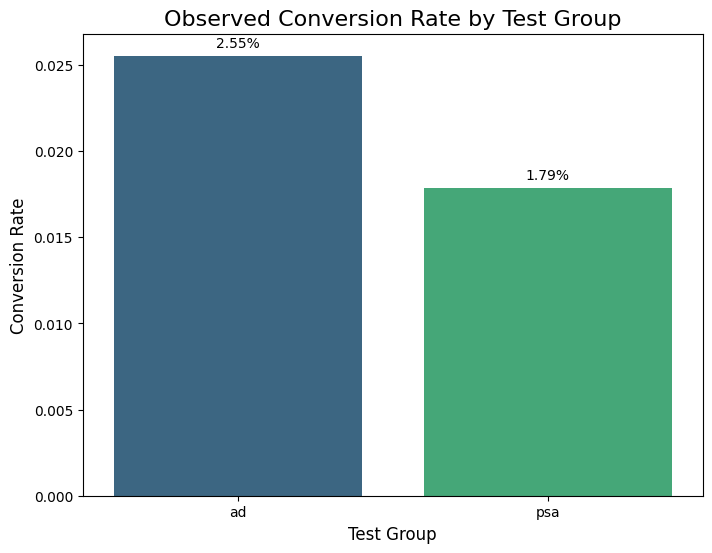

In [4]:
# --- Calculate conversion rates for each group ---

# We can group by 'test_group' and then calculate the mean of the 'converted' column.
# Since True=1 and False=0, the mean is the same as the conversion rate.
conversion_rates = df.groupby('test_group')['converted'].mean()

print("--- Observed Conversion Rates ---")
# We multiply by 100 to express it as a percentage.
print(round(conversion_rates * 100, 2))


# --- Visualize the conversion rates ---
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette='viridis', hue=conversion_rates.index, legend=False)

plt.title('Observed Conversion Rate by Test Group', fontsize=16)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xlabel('Test Group', fontsize=12)

# Add percentage labels on top of the bars for clarity
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')
plt.show()

**Initial Observation:**

The initial results are promising. The group that saw the **ad** had an observed conversion rate of **2.55%**, while the group that saw the **PSA** had a conversion rate of **1.78%**.

On the surface, the ad seems to have performed better. However, the crucial question is: **is this difference large enough to be statistically significant, or could it have just occurred due to random chance?**

To answer this, we must perform a formal hypothesis test.

## 4. Statistical Test Execution

To formally test our hypothesis, we will use the **Chi-Squared Test of Independence**. This test is the perfect tool for our scenario because it's designed to determine if there is a significant association between two categorical variables. In our case, these variables are:

1.  **`test_group`** (with categories: 'ad', 'psa')
2.  **`converted`** (with categories: True, False)

The test will compare our *observed* counts of converted/not-converted users in each group to the counts we would *expect* to see if there were no relationship between the two variables (i.e., if the null hypothesis were true).

### 4.1 Creating the Contingency Table

The first step is to create a **contingency table**, which is a simple 2x2 table that shows the raw counts for each combination of our two variables.

In [5]:
# The pd.crosstab() function is designed for exactly this purpose.
contingency_table = pd.crosstab(df['test_group'], df['converted'])

print("--- Contingency Table ---")
print(contingency_table)

--- Contingency Table ---
converted    False  True 
test_group               
ad          550154  14423
psa          23104    420


### 4.2 Performing the Chi-Squared Test

Now that we have our contingency table, we can pass it directly into the Chi-Squared function from the `scipy.stats` library. This function will return several values, but we are primarily interested in the **p-value**.

In [6]:
# Import the chi2_contingency function from scipy's stats library
from scipy.stats import chi2_contingency

# The chi2_contingency function takes the contingency table as input
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# --- Print the results in a clear, readable format ---
print(f"--- Chi-Squared Test Results ---")
print(f"Chi-Squared Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")
# The 'expected' variable contains the expected counts under the null hypothesis
# print("\nExpected Frequencies:")
# print(expected)

--- Chi-Squared Test Results ---
Chi-Squared Statistic: 54.0058
P-value: 0.0000
Degrees of Freedom: 1


# Interpretation

The Statistical Conclusion: Our calculated p-value (0.0000) is much smaller than our chosen significance level of α = 0.05.

The Action: Therefore, we reject the null hypothesis (H₀).

The Business Interpretation: We have strong statistical evidence to conclude that there is a significant difference in the conversion rates between the ad group and the psa group. The difference we observed is not just due to random chance. The ad campaign was effective at increasing conversions.


## 5. Conclusion & Business Recommendation

The final step is to interpret the results of our statistical test and translate them into a clear recommendation for the business.

### 5.1 Statistical Conclusion
The Chi-Squared Test of Independence yielded a p-value of approximately **0.0000**. This value is significantly less than our chosen significance level of **α = 0.05**.

Based on this result, we **reject the null hypothesis**. This means we have strong statistical evidence to conclude that there is a significant association between the test group and the conversion outcome. The observed difference in conversion rates (2.55% for the `ad` group vs. 1.78% for the `psa` group) is not due to random chance.

### 5.2 Business Recommendation

**The ad campaign was a success.**

The data shows with a high degree of statistical confidence that the advertisement was effective at increasing the user conversion rate compared to the public service announcement.

**Recommendation:**
The company should proceed with a full rollout of this advertising campaign. The increased conversion rate, while seemingly small in percentage terms, can lead to a substantial increase in revenue when applied to the entire user base.

**Further Analysis (Optional):**
As a next step, an analysis could be conducted to determine the Return on Ad Spend (ROAS). By combining the uplift in conversions with the cost of the campaign, the total financial benefit could be quantified, providing an even stronger business case for the campaign's rollout.

### 5.3 Assumptions and Further Considerations

While our statistical test provides a clear result based on the data provided, a comprehensive A/B test analysis in a real-world business context would also involve validating several assumptions about the experimental design. For this portfolio project, we proceed based on the assumption that the experiment was well-designed.

Key considerations for a full-scale analysis would include:

*   **Randomization:** We assume that users were randomly and evenly assigned to the `ad` and `psa` groups, preventing any selection bias.
*   **Sample Size & Power:** The large sample size in this dataset gives us confidence in the result. In a real-world scenario, a "power analysis" would be conducted *before* the test to ensure the sample size was sufficient to detect a meaningful effect.
*   **Novelty Effect & Test Duration:** We assume the test was run for a sufficient duration to mitigate any "novelty effect" (where users interact with a new feature simply because it is new).
*   **No "Peeking":** We assume the test was not stopped prematurely as soon as the results appeared significant, as this can inflate the false positive rate.

Acknowledging these factors is a crucial part of a robust A/B testing framework.

## 6. (Optional) Financial Impact Analysis: Return on Ad Spend

While our statistical test confirmed the campaign's effectiveness in increasing conversions, the ultimate business question is about financial impact. To assess this, we can estimate the Return on Ad Spend (ROAS).

This requires two key pieces of information not present in the dataset: the **total cost of the campaign** and the **average revenue per conversion**. For this analysis, we will proceed with the following reasonable assumptions, which in a real-world scenario would be provided by the marketing and finance departments.

### 6.1 Assumptions

*   **Average Revenue Per Conversion (ARPU):** We will assume that each successful conversion (a purchase) generates an average of **25.00usd** in revenue for the company.
*   **Total Campaign Cost:** We will assume the total cost to run the ad campaign (including ad spend and creative) was **150,000usd**. We only consider the cost of the `ad` group, as the `psa` group would be considered a baseline or control cost.

With these assumptions, we can calculate the financial lift provided by the ad.

In [7]:
# --- 1. Define our assumptions ---
ARPU = 25.00  # Average Revenue Per User/Conversion
CAMPAIGN_COST = 150000.00

# --- 2. Get the number of conversions from our contingency table ---
# The table has groups as index and converted (False/True) as columns
ad_conversions = contingency_table.loc['ad', True]
psa_conversions = contingency_table.loc['psa', True]
print(f"Number of conversions from AD group: {ad_conversions}")
print(f"Number of conversions from PSA group: {psa_conversions}\n")

# --- 3. Calculate total revenue generated by each group ---
ad_revenue = ad_conversions * ARPU
psa_revenue = psa_conversions * ARPU
print(f"Total revenue from AD group: ${ad_revenue:,.2f}")
print(f"Total revenue from PSA group: ${psa_revenue:,.2f}\n")


# --- 4. Calculate the financial lift and ROAS ---
# The 'lift' is the extra revenue generated by the ad campaign.
revenue_lift = ad_revenue - psa_revenue
print(f"Revenue Lift attributable to the ad campaign: ${revenue_lift:,.2f}")

# ROAS = (Revenue from Ad / Cost of Ad). A value > 1 means it was profitable.
roas = ad_revenue / CAMPAIGN_COST
print(f"Return on Ad Spend (ROAS): {roas:.2f}")

# We can also calculate the Cost Per Acquisition (CPA)
cpa = CAMPAIGN_COST / ad_conversions
print(f"Cost Per Acquisition (CPA): ${cpa:.2f}")

Number of conversions from AD group: 14423
Number of conversions from PSA group: 420

Total revenue from AD group: $360,575.00
Total revenue from PSA group: $10,500.00

Revenue Lift attributable to the ad campaign: $350,075.00
Return on Ad Spend (ROAS): 2.40
Cost Per Acquisition (CPA): $10.40


### 6.2 Financial Conclusion

Based on our assumptions, the financial analysis provides a clear picture of the campaign's value:

*   **Revenue:** The ad group generated **360,575 usd** in revenue, compared to **10,500 usd** from the PSA group.
*   **Return on Ad Spend (ROAS):** With a ROAS of **2.40**, the campaign was highly profitable. For every **1.00 usd** spent on the ad campaign, the company generated **2.40 usd** in revenue.
*   **Cost Per Acquisition (CPA):** The cost to acquire a new customer through this campaign was **10.40 usd**, which can be compared against the company's target CPA benchmarks.

**Final Recommendation:**
The ad campaign was not only statistically effective but also financially profitable. The recommendation to proceed with a full rollout is strongly supported by this financial analysis. The company can expect a positive return on its investment based on these results.